In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler

In [ ]:
import argparse
import datetime
import os
import re
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")  # Report only TF errors by default

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
import typing
if typing.TYPE_CHECKING:
    from keras.api._v2 import keras

# Simple NN

In [ ]:
seed = 42
# Load the CSV file
data = pd.read_csv("BC-Data-Set.csv")
# Convert the date column to a datetime object
data['date'] = pd.to_datetime(data['date'])

# Remove any missing values
data = data.dropna()

# Set the date column as the index of the DataFrame
data = data.set_index('date')
x_train, x_test, y_train, y_test = train_test_split(data, data.BC, test_size=0.15, random_state=seed, shuffle=True)
x_train = x_train.drop(columns=['BC'])
x_test = x_test.drop(columns=['BC'])

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, random_state=seed, shuffle=True)

SCALE = True
if SCALE:
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)
    x_test = scaler.transform(x_test)

In [ ]:
HIDDEN_SIZE = 32
batch_size = 256

x = keras.Input([x_train.shape[-1]])
y = keras.layers.Dense(HIDDEN_SIZE, activation=keras.activations.relu)(x)
y = keras.layers.Dense(HIDDEN_SIZE, activation=keras.activations.relu)(y)
y = keras.layers.Dense(1, activation=None)(y)

model = keras.Model(inputs=x, outputs=y)

model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.mean_squared_error,
        metrics=[tfa.metrics.RSquare()],
    )

model.summary()

In [ ]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = batch_size,
    epochs = 500,
    validation_data=(x_val, y_val),
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True),
        # tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
)

In [ ]:
plt.ylim(0, 1)
plt.suptitle(f'RMSE')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [ ]:
val_rmse = min(history.history['val_loss'])
val_rmse

In [ ]:
plt.suptitle(f'R2')
plt.plot(history.history['r_square'], label='train')
plt.plot(history.history['val_r_square'], label='val')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [ ]:
val_r2 = max(history.history['val_r_square'])
val_r2

Simple NN:
I can get much lower VAL RMSE and about the same R2 score. Lower batch size seems better but takes long time to run (and maybe we're just overfitting). Two layers of 32 or 64 give good results on DEV. 

Preprocessing effect: No large spikes at the begginng (which was to be expected actually). Probably better RMSE, R2 seems the same I guess.

Previous results:

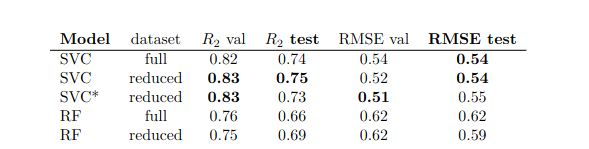

## Test

In [ ]:
y_pred = model.predict(x_test, batch_size=256, verbose=1)
y_pred = y_pred.flatten()

In [ ]:
test_rmse = keras.metrics.mean_squared_error(y_test, y_pred).numpy()
test_rmse = np.sqrt(test_rmse)
test_rmse

In [ ]:
test_r2 = tfa.metrics.RSquare()(y_test, y_pred).numpy()
test_r2

In [ ]:
model.summary()

In [ ]:
val_rmse, test_rmse

In [ ]:
val_r2, test_r2

## Experiments

In [ ]:
from tqdm import tqdm

In [ ]:
# res = []
# batch_size = 256

# for hs in tqdm([8, 16, 32, 64, 256]):
#     for nl in [1, 2, 3, 4]:        
#         x = keras.Input([x_train.shape[-1]])
#         y = keras.layers.Dense(hs, activation=keras.activations.relu)(x)
#         for _ in range(nl - 1):
#             y = keras.layers.Dense(hs, activation=keras.activations.relu)(y)
#         y = keras.layers.Dense(1, activation=None)(y)

#         model = keras.Model(inputs=x, outputs=y)

#         model.compile(
#                 optimizer=keras.optimizers.Adam(learning_rate=1e-3),
#                 loss=keras.losses.mean_squared_error,
#                 metrics=[tfa.metrics.RSquare()],
#             )
#         history = model.fit(
#             x = x_train,
#             y = y_train,
#             batch_size = batch_size,
#             epochs = 500,
#             verbose=0,
#             validation_split=0.15,
#             callbacks = [
#                 tf.keras.callbacks.EarlyStopping(monitor='val_r_square', mode='max', patience=30, restore_best_weights=True),
#                 # tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=30, restore_best_weights=True),
#                 # tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
#             ]
#         )
#         val_rmse = min(history.history['val_loss'])
#         train_rmse = min(history.history['loss'])
#         val_r2 = max(history.history['val_r_square'])
#         train_r2 = max(history.history['r_square'])
#         res.append({
#             'hidden_size': hs,
#             'number_of_layers': nl,
#             'train_rmse': train_rmse,
#             'val_rmse': val_rmse,
#             'train_r2': train_r2,
#             'val_r2': val_r2,
#             'parameters_count': model.count_params(),
#         })

In [ ]:
# df = pd.DataFrame(res)

In [ ]:
def heatmap(df, rows, columns, values, aggfunc=np.mean):
    if aggfunc is None:
        heatmap_data = df.pivot(index=rows, columns=columns, values=values)
    else:
        heatmap_data = df.pivot_table(index=rows, columns=columns, values=values, aggfunc=aggfunc)
    fig, ax = plt.subplots(figsize=(12,6))
    x_range = heatmap_data.columns
    y_range = heatmap_data.index

    heatmap = ax.imshow(
        heatmap_data,
        interpolation="nearest",
        cmap=plt.cm.hot,
        # vmax=np.median(heatmap_data.values) * 3,
    )

    data = heatmap_data.values
    median = np.median(data)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            c = 'black' if data[i, j] >= median else 'white'
            ax.text(j, i, f'{data[i, j]:.2f}', ha='center', va='center', color=c, fontsize=10)


    ax.set_xlabel(columns)
    ax.set_ylabel(rows)
    plt.colorbar(heatmap, ax=ax)
    ax.set_xticks(np.arange(len(x_range)), x_range, rotation=45)
    ax.set_yticks(np.arange(len(y_range)), y_range)
    plt.title(values)
    plt.show()

In [ ]:
# len(df)

In [ ]:
# columns = 'hidden_size'
# rows = 'number_of_layers'
# heatmap(df, rows, columns, 'val_rmse')
# heatmap(df, rows, columns, 'val_r2')

In [ ]:
# heatmap(df, rows, columns, 'parameters_count')

# LSTM

In [ ]:
seed = 42
# Load the CSV file
data = pd.read_csv("BC-Data-Set.csv")
# Convert the date column to a datetime object
data['date'] = pd.to_datetime(data['date'])

# Remove any missing values
data = data.dropna()

# Set the date column as the index of the DataFrame
data = data.set_index('date')

In [ ]:
train_len = round(len(data) * 0.85)

In [ ]:
x_train_raw = data.iloc[:train_len].drop(columns=['BC'])
x_train_idx = x_train_raw.index
y_train_raw = data.iloc[:train_len]['BC']
x_test_raw = data.iloc[train_len:].drop(columns=['BC'])
x_test_idx = x_test_raw.index
y_test_raw = data.iloc[train_len:]['BC']


SCALE = True
if SCALE:
    scaler = StandardScaler()
    # this returns numpy array
    x_train_raw = scaler.fit_transform(x_train_raw)
    x_train_raw = pd.DataFrame(x_train_raw, columns=scaler.get_feature_names_out())
    x_train_raw = x_train_raw.set_index(x_train_idx)
    x_test_raw = pd.DataFrame(scaler.transform(x_test_raw), columns=scaler.get_feature_names_out())
    x_test_raw = x_test_raw.set_index(x_test_idx)

In [ ]:
plt.plot(y_train_raw)
plt.plot(y_test_raw)

In [ ]:
from tqdm import tqdm

In [ ]:
def build_dataset(x_raw, y_raw, window_len = 24):
    X_time = []
    if SCALE:
        mean_row = np.zeros_like(x_raw.mean())
    else:
        mean_row = x_raw.mean().values
    # y_time = []
    for index, row in tqdm(x_raw.iterrows()):
        x = []
        y = []
        # starts from 0 to include current
        for dt in range(window_len):
            prev_idx = index - pd.Timedelta(hours=dt)
            if prev_idx in x_raw.index:
                prev = x_raw.loc[prev_idx]
                # prev_y = y_raw.loc[prev_idx]
            else:
                prev = mean_row.copy()
            x.append(prev)
            # y.append(prev_y)
        x.reverse()
        y.reverse()
        X_time.append(x)
        # y_time.append(y)
    return np.array(X_time), np.array(y_raw)

In [ ]:
x_train, y_train = build_dataset(x_train_raw, y_train_raw)
_i = round(0.85 * len(x_train))
x_dev = x_train[_i:]
y_dev = y_train[_i:]
x_train = x_train[:_i]
y_train = y_train[:_i]

In [ ]:
x_train.shape, x_dev.shape

In [ ]:
HIDDEN_SIZE = 32
batch_size = 8

x = keras.Input(x_train.shape[1:])
y = keras.layers.LSTM(HIDDEN_SIZE, return_sequences=False)(x)
y = keras.layers.Dense(1, activation=None)(y)

model = keras.Model(inputs=x, outputs=y)

model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.mean_squared_error,
        metrics=[tfa.metrics.RSquare()],
    )

model.summary()

In [ ]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = batch_size,
    epochs = 500,
    validation_data=(x_dev, y_dev),
    shuffle=True,
    callbacks = [
        # tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True),
        tf.keras.callbacks.EarlyStopping(monitor='val_r_square', mode='max', patience=20, restore_best_weights=True),
        # tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
)

In [ ]:
plt.ylim(0, 1)
plt.suptitle(f'RMSE')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [ ]:
val_rmse = min(history.history['val_loss'])
val_rmse

In [ ]:
plt.suptitle(f'R2')
plt.plot(history.history['r_square'], label='train')
plt.plot(history.history['val_r_square'], label='val')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [ ]:
val_r2 = max(history.history['val_r_square'])
val_r2

## Test

In [ ]:
x_test, y_test = build_dataset(x_test_raw, y_test_raw)
x_test.shape

In [ ]:
y_pred = model.predict(x_test, batch_size=256, verbose=1)
y_pred = y_pred.flatten()

In [ ]:
test_rmse = keras.metrics.mean_squared_error(y_test, y_pred).numpy()
test_rmse = np.sqrt(test_rmse)
test_rmse

In [ ]:
test_r2 = tfa.metrics.RSquare()(y_test, y_pred).numpy()
test_r2

In [ ]:
model.summary()

In [ ]:
print('window_len = 24')

In [ ]:
val_rmse, test_rmse

In [ ]:
val_r2, test_r2

# Window size

In [ ]:
def build_and_eval(w_len):
    x_train, y_train = build_dataset(x_train_raw, y_train_raw, window_len=w_len)
    _i = round(0.85 * len(x_train))
    x_dev = x_train[_i:]
    y_dev = y_train[_i:]
    x_train = x_train[:_i]
    y_train = y_train[:_i]


    HIDDEN_SIZE = 32
    batch_size = 128

    x = keras.Input(x_train.shape[1:])
    y = keras.layers.Bidirectional(
            keras.layers.LSTM(HIDDEN_SIZE, return_sequences=True),
            merge_mode="concat"
        )(x)
    y = keras.layers.Bidirectional(
        keras.layers.LSTM(HIDDEN_SIZE // 2, return_sequences=False),
        merge_mode="concat"
    )(y)
    y = keras.layers.Dense(1, activation=None)(y)

    model = keras.Model(inputs=x, outputs=y)

    model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=1e-3),
            loss=keras.losses.mean_squared_error,
            metrics=[tfa.metrics.RSquare()],
        )

    model.summary()

    history = model.fit(
        x = x_train,
        y = y_train,
        batch_size = batch_size,
        epochs = 500,
        validation_data=(x_dev, y_dev),
        shuffle=True,
        verbose=0,
        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor='val_r_square', mode='max', patience=20, restore_best_weights=True),
        ]
    )
    val_rmse = min(history.history['val_loss'])
    val_r2 = max(history.history['val_r_square'])
    return {
        'w_len': w_len,
        'history': history,
        'val_rmse': val_rmse,
        'val_r2': val_r2,
    }
    

In [ ]:
# res = []

In [ ]:
# r = build_and_eval(1)
# res.append(r)
# r

In [ ]:
# for w_len in range(2, 48, 2):
#     r = build_and_eval(w_len)
#     print(w_len, 'done')
#     res.append(r)

In [ ]:
# df = pd.DataFrame(res)
# df = df.sort_values('w_len').reset_index(drop=True)
# df

In [ ]:
# df['train_rmse'] = df.history.map(lambda x: min(x.history['loss']))
# df['train_r2'] = df.history.map(lambda x: max(x.history['r_square']))

In [ ]:
# df.to_csv('lstm_winlen.csv', index=False)

In [ ]:
df = pd.read_csv('lstm_winlen.csv')

In [ ]:
df

In [ ]:
df.drop(columns='history').groupby('w_len').mean()

In [ ]:
ax = sns.lineplot(df, x='w_len', y='train_rmse', label='train')
ax = sns.lineplot(df, x='w_len', y='val_rmse', ax=ax, label='val')
ax.legend()
ax.set_ylabel('RMSE')
ax.set_xlabel('window length')
ax.set_ylim(0, 1)

In [ ]:
ax = sns.lineplot(df, x='w_len', y='train_r2', label='train')
ax = sns.lineplot(df, x='w_len', y='val_r2', ax=ax, label='val')
ax.legend()
ax.set_ylabel('R2')
ax.set_xlabel('window length')
ax.set_ylim(0, 1)